# **CNN** *Pytorch*

### **Imports...**

In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

### **GPU/MPS/CPU...**

In [2]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [3]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x
print(
    f"~~~~~~~~~ \n"
    f"CNN ready! \n"
    f"~~~~~~~~~")

~~~~~~~~~ 
CNN ready! 
~~~~~~~~~


### **Hyperparamethers...**

In [4]:
num_classes = 26 
learning_rate = 0.005
batch_size = 128
num_epochs = 80
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [5]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

train_dataset = datasets.EMNIST(root='emnist-letters-train',split='letters', train=True, download=True, transform=train_transform(), target_transform=lambda y: y-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [6]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [8]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TRAINING 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        scores = model(data) # Forward
        loss = criterion(scores, targets)

        loss.backward() # Backward
        optimizer.step()

        batch_size = targets.size(0)
        train_loss += loss.item() * batch_size
        
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_total += batch_size
    
    train_loss /= train_total
    train_acc = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # EVALUATION 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            
            loss = criterion(scores, y)
            batch_size = y.size(0)
            test_loss += loss.item() * batch_size

            _, predictions = scores.max(1) 
            test_correct += (predictions == y).sum().item() 
            test_total += batch_size

    test_loss /= test_total
    test_acc = float(test_correct) / float(test_total) * 100.0
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
        
    print(
        f" \n "
        f"|~|TRAINING:|~| Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}. \n "
        f"|~|TESTING:|~| Accuracy: {test_acc:.2f}, Loss: {test_loss:.4f}. \n " 
        f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        )
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SCHEDULER 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    scheduler.step()

    print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FINAL METRICS 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
final_train_loss = train_losses[-1]
final_train_acc = train_accuracies[-1]
final_test_loss = test_losses[-1]
final_test_acc = test_accuracies[-1]

print("===== Training Complete =====")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
    

Epoch [1/80]
Learning rate: 0.005000


100%|██████████| 975/975 [01:07<00:00, 14.52it/s]


 
 |~|TRAINING:|~| Accuracy: 52.64, Loss: 1.4867. 
 |~|TESTING:|~| Accuracy: 86.17, Loss: 0.4478. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [2/80]
Learning rate: 0.004998


100%|██████████| 975/975 [01:05<00:00, 14.97it/s]


 
 |~|TRAINING:|~| Accuracy: 77.89, Loss: 0.7037. 
 |~|TESTING:|~| Accuracy: 90.80, Loss: 0.2841. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [3/80]
Learning rate: 0.004992


100%|██████████| 975/975 [01:05<00:00, 14.92it/s]


 
 |~|TRAINING:|~| Accuracy: 82.61, Loss: 0.5514. 
 |~|TESTING:|~| Accuracy: 92.04, Loss: 0.2377. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [4/80]
Learning rate: 0.004983


100%|██████████| 975/975 [01:07<00:00, 14.53it/s]


 
 |~|TRAINING:|~| Accuracy: 84.79, Loss: 0.4812. 
 |~|TESTING:|~| Accuracy: 92.95, Loss: 0.2120. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [5/80]
Learning rate: 0.004969


100%|██████████| 975/975 [01:03<00:00, 15.28it/s]


 
 |~|TRAINING:|~| Accuracy: 86.16, Loss: 0.4430. 
 |~|TESTING:|~| Accuracy: 92.86, Loss: 0.2171. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [6/80]
Learning rate: 0.004952


100%|██████████| 975/975 [01:03<00:00, 15.32it/s]


 
 |~|TRAINING:|~| Accuracy: 86.83, Loss: 0.4185. 
 |~|TESTING:|~| Accuracy: 93.59, Loss: 0.1948. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [7/80]
Learning rate: 0.004931


100%|██████████| 975/975 [01:03<00:00, 15.36it/s]


 
 |~|TRAINING:|~| Accuracy: 87.63, Loss: 0.3927. 
 |~|TESTING:|~| Accuracy: 93.65, Loss: 0.1916. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [8/80]
Learning rate: 0.004906


100%|██████████| 975/975 [01:03<00:00, 15.35it/s]


 
 |~|TRAINING:|~| Accuracy: 88.07, Loss: 0.3795. 
 |~|TESTING:|~| Accuracy: 93.76, Loss: 0.1925. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [9/80]
Learning rate: 0.004878


100%|██████████| 975/975 [01:05<00:00, 14.99it/s]


 
 |~|TRAINING:|~| Accuracy: 88.61, Loss: 0.3615. 
 |~|TESTING:|~| Accuracy: 93.76, Loss: 0.1892. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [10/80]
Learning rate: 0.004845


100%|██████████| 975/975 [01:04<00:00, 15.14it/s]


 
 |~|TRAINING:|~| Accuracy: 88.96, Loss: 0.3509. 
 |~|TESTING:|~| Accuracy: 93.75, Loss: 0.1891. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [11/80]
Learning rate: 0.004810


100%|██████████| 975/975 [01:03<00:00, 15.33it/s]


 
 |~|TRAINING:|~| Accuracy: 89.49, Loss: 0.3370. 
 |~|TESTING:|~| Accuracy: 94.05, Loss: 0.1841. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [12/80]
Learning rate: 0.004770


100%|██████████| 975/975 [01:03<00:00, 15.35it/s]


 
 |~|TRAINING:|~| Accuracy: 89.71, Loss: 0.3292. 
 |~|TESTING:|~| Accuracy: 94.08, Loss: 0.1781. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [13/80]
Learning rate: 0.004728


100%|██████████| 975/975 [01:03<00:00, 15.36it/s]


 
 |~|TRAINING:|~| Accuracy: 89.83, Loss: 0.3204. 
 |~|TESTING:|~| Accuracy: 93.99, Loss: 0.1810. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [14/80]
Learning rate: 0.004681


100%|██████████| 975/975 [01:03<00:00, 15.34it/s]


 
 |~|TRAINING:|~| Accuracy: 89.93, Loss: 0.3165. 
 |~|TESTING:|~| Accuracy: 94.21, Loss: 0.1734. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [15/80]
Learning rate: 0.004632


100%|██████████| 975/975 [01:04<00:00, 15.21it/s]


 
 |~|TRAINING:|~| Accuracy: 90.13, Loss: 0.3114. 
 |~|TESTING:|~| Accuracy: 94.02, Loss: 0.1842. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [16/80]
Learning rate: 0.004579


100%|██████████| 975/975 [01:04<00:00, 15.10it/s]


 
 |~|TRAINING:|~| Accuracy: 90.44, Loss: 0.3019. 
 |~|TESTING:|~| Accuracy: 94.04, Loss: 0.1791. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [17/80]
Learning rate: 0.004523


100%|██████████| 975/975 [01:04<00:00, 15.15it/s]


 
 |~|TRAINING:|~| Accuracy: 90.48, Loss: 0.3006. 
 |~|TESTING:|~| Accuracy: 94.30, Loss: 0.1828. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [18/80]
Learning rate: 0.004463


100%|██████████| 975/975 [01:04<00:00, 15.12it/s]


 
 |~|TRAINING:|~| Accuracy: 90.59, Loss: 0.2964. 
 |~|TESTING:|~| Accuracy: 94.55, Loss: 0.1703. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [19/80]
Learning rate: 0.004401


100%|██████████| 975/975 [01:04<00:00, 15.04it/s]


 
 |~|TRAINING:|~| Accuracy: 90.71, Loss: 0.2912. 
 |~|TESTING:|~| Accuracy: 94.42, Loss: 0.1690. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [20/80]
Learning rate: 0.004336


100%|██████████| 975/975 [01:04<00:00, 15.14it/s]


 
 |~|TRAINING:|~| Accuracy: 90.98, Loss: 0.2860. 
 |~|TESTING:|~| Accuracy: 94.36, Loss: 0.1733. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [21/80]
Learning rate: 0.004268


100%|██████████| 975/975 [01:04<00:00, 15.13it/s]


 
 |~|TRAINING:|~| Accuracy: 91.01, Loss: 0.2848. 
 |~|TESTING:|~| Accuracy: 94.53, Loss: 0.1679. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [22/80]
Learning rate: 0.004197


100%|██████████| 975/975 [01:04<00:00, 15.11it/s]


 
 |~|TRAINING:|~| Accuracy: 91.02, Loss: 0.2829. 
 |~|TESTING:|~| Accuracy: 94.25, Loss: 0.1748. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [23/80]
Learning rate: 0.004124


100%|██████████| 975/975 [01:04<00:00, 15.12it/s]


 
 |~|TRAINING:|~| Accuracy: 91.04, Loss: 0.2790. 
 |~|TESTING:|~| Accuracy: 94.39, Loss: 0.1748. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [24/80]
Learning rate: 0.004048


100%|██████████| 975/975 [01:04<00:00, 15.12it/s]


 
 |~|TRAINING:|~| Accuracy: 91.20, Loss: 0.2730. 
 |~|TESTING:|~| Accuracy: 94.55, Loss: 0.1711. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [25/80]
Learning rate: 0.003969


100%|██████████| 975/975 [01:05<00:00, 14.92it/s]


 
 |~|TRAINING:|~| Accuracy: 91.29, Loss: 0.2720. 
 |~|TESTING:|~| Accuracy: 94.67, Loss: 0.1673. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [26/80]
Learning rate: 0.003889


100%|██████████| 975/975 [01:04<00:00, 15.02it/s]


 
 |~|TRAINING:|~| Accuracy: 91.39, Loss: 0.2678. 
 |~|TESTING:|~| Accuracy: 94.52, Loss: 0.1709. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [27/80]
Learning rate: 0.003806


100%|██████████| 975/975 [01:04<00:00, 15.07it/s]


 
 |~|TRAINING:|~| Accuracy: 91.51, Loss: 0.2672. 
 |~|TESTING:|~| Accuracy: 94.54, Loss: 0.1685. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [28/80]
Learning rate: 0.003722


100%|██████████| 975/975 [01:04<00:00, 15.11it/s]


 
 |~|TRAINING:|~| Accuracy: 91.48, Loss: 0.2666. 
 |~|TESTING:|~| Accuracy: 94.55, Loss: 0.1706. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [29/80]
Learning rate: 0.003635


100%|██████████| 975/975 [01:04<00:00, 15.06it/s]


 
 |~|TRAINING:|~| Accuracy: 91.66, Loss: 0.2616. 
 |~|TESTING:|~| Accuracy: 94.79, Loss: 0.1658. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [30/80]
Learning rate: 0.003547


100%|██████████| 975/975 [01:04<00:00, 15.04it/s]


 
 |~|TRAINING:|~| Accuracy: 91.65, Loss: 0.2613. 
 |~|TESTING:|~| Accuracy: 94.63, Loss: 0.1631. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [31/80]
Learning rate: 0.003457


100%|██████████| 975/975 [01:04<00:00, 15.04it/s]


 
 |~|TRAINING:|~| Accuracy: 91.90, Loss: 0.2535. 
 |~|TESTING:|~| Accuracy: 94.74, Loss: 0.1650. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [32/80]
Learning rate: 0.003365


100%|██████████| 975/975 [01:07<00:00, 14.52it/s]


 
 |~|TRAINING:|~| Accuracy: 91.74, Loss: 0.2532. 
 |~|TESTING:|~| Accuracy: 94.64, Loss: 0.1657. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [33/80]
Learning rate: 0.003273


100%|██████████| 975/975 [01:07<00:00, 14.45it/s]


 
 |~|TRAINING:|~| Accuracy: 91.88, Loss: 0.2539. 
 |~|TESTING:|~| Accuracy: 94.77, Loss: 0.1615. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [34/80]
Learning rate: 0.003179


100%|██████████| 975/975 [01:16<00:00, 12.79it/s]


 
 |~|TRAINING:|~| Accuracy: 91.97, Loss: 0.2520. 
 |~|TESTING:|~| Accuracy: 94.79, Loss: 0.1638. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [35/80]
Learning rate: 0.003084


100%|██████████| 975/975 [01:08<00:00, 14.16it/s]


 
 |~|TRAINING:|~| Accuracy: 92.04, Loss: 0.2478. 
 |~|TESTING:|~| Accuracy: 94.82, Loss: 0.1651. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [36/80]
Learning rate: 0.002988


100%|██████████| 975/975 [01:04<00:00, 15.11it/s]


 
 |~|TRAINING:|~| Accuracy: 92.10, Loss: 0.2453. 
 |~|TESTING:|~| Accuracy: 94.59, Loss: 0.1645. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [37/80]
Learning rate: 0.002891


100%|██████████| 975/975 [01:07<00:00, 14.43it/s]


 
 |~|TRAINING:|~| Accuracy: 92.14, Loss: 0.2435. 
 |~|TESTING:|~| Accuracy: 94.79, Loss: 0.1614. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [38/80]
Learning rate: 0.002794


100%|██████████| 975/975 [01:05<00:00, 14.98it/s]


 
 |~|TRAINING:|~| Accuracy: 92.22, Loss: 0.2415. 
 |~|TESTING:|~| Accuracy: 94.84, Loss: 0.1634. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [39/80]
Learning rate: 0.002696


100%|██████████| 975/975 [01:05<00:00, 14.97it/s]


 
 |~|TRAINING:|~| Accuracy: 92.29, Loss: 0.2399. 
 |~|TESTING:|~| Accuracy: 95.00, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [40/80]
Learning rate: 0.002598


100%|██████████| 975/975 [01:05<00:00, 14.82it/s]


 
 |~|TRAINING:|~| Accuracy: 92.35, Loss: 0.2364. 
 |~|TESTING:|~| Accuracy: 94.69, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [41/80]
Learning rate: 0.002500


100%|██████████| 975/975 [01:05<00:00, 14.80it/s]


 
 |~|TRAINING:|~| Accuracy: 92.39, Loss: 0.2344. 
 |~|TESTING:|~| Accuracy: 94.64, Loss: 0.1656. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [42/80]
Learning rate: 0.002402


100%|██████████| 975/975 [01:06<00:00, 14.76it/s]


 
 |~|TRAINING:|~| Accuracy: 92.44, Loss: 0.2328. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1586. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [43/80]
Learning rate: 0.002304


100%|██████████| 975/975 [01:06<00:00, 14.73it/s]


 
 |~|TRAINING:|~| Accuracy: 92.44, Loss: 0.2354. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1573. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [44/80]
Learning rate: 0.002206


100%|██████████| 975/975 [01:11<00:00, 13.70it/s]


 
 |~|TRAINING:|~| Accuracy: 92.60, Loss: 0.2289. 
 |~|TESTING:|~| Accuracy: 94.91, Loss: 0.1609. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [45/80]
Learning rate: 0.002109


100%|██████████| 975/975 [01:07<00:00, 14.42it/s]


 
 |~|TRAINING:|~| Accuracy: 92.62, Loss: 0.2276. 
 |~|TESTING:|~| Accuracy: 94.99, Loss: 0.1564. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [46/80]
Learning rate: 0.002012


100%|██████████| 975/975 [01:07<00:00, 14.43it/s]


 
 |~|TRAINING:|~| Accuracy: 92.78, Loss: 0.2253. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1585. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [47/80]
Learning rate: 0.001916


100%|██████████| 975/975 [01:07<00:00, 14.44it/s]


 
 |~|TRAINING:|~| Accuracy: 92.76, Loss: 0.2238. 
 |~|TESTING:|~| Accuracy: 95.00, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [48/80]
Learning rate: 0.001821


100%|██████████| 975/975 [01:07<00:00, 14.39it/s]


 
 |~|TRAINING:|~| Accuracy: 92.85, Loss: 0.2202. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1590. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [49/80]
Learning rate: 0.001727


100%|██████████| 975/975 [01:07<00:00, 14.35it/s]


 
 |~|TRAINING:|~| Accuracy: 92.77, Loss: 0.2216. 
 |~|TESTING:|~| Accuracy: 95.00, Loss: 0.1551. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [50/80]
Learning rate: 0.001635


100%|██████████| 975/975 [01:08<00:00, 14.21it/s]


 
 |~|TRAINING:|~| Accuracy: 92.92, Loss: 0.2207. 
 |~|TESTING:|~| Accuracy: 94.87, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [51/80]
Learning rate: 0.001543


100%|██████████| 975/975 [01:08<00:00, 14.20it/s]


 
 |~|TRAINING:|~| Accuracy: 92.86, Loss: 0.2202. 
 |~|TESTING:|~| Accuracy: 94.95, Loss: 0.1608. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [52/80]
Learning rate: 0.001453


100%|██████████| 975/975 [01:08<00:00, 14.16it/s]


 
 |~|TRAINING:|~| Accuracy: 92.97, Loss: 0.2164. 
 |~|TESTING:|~| Accuracy: 94.94, Loss: 0.1556. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [53/80]
Learning rate: 0.001365


100%|██████████| 975/975 [01:09<00:00, 14.06it/s]


 
 |~|TRAINING:|~| Accuracy: 92.93, Loss: 0.2169. 
 |~|TESTING:|~| Accuracy: 95.05, Loss: 0.1568. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [54/80]
Learning rate: 0.001278


100%|██████████| 975/975 [01:13<00:00, 13.28it/s]


 
 |~|TRAINING:|~| Accuracy: 92.99, Loss: 0.2147. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1575. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [55/80]
Learning rate: 0.001194


100%|██████████| 975/975 [01:07<00:00, 14.42it/s]


 
 |~|TRAINING:|~| Accuracy: 93.09, Loss: 0.2129. 
 |~|TESTING:|~| Accuracy: 95.07, Loss: 0.1543. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [56/80]
Learning rate: 0.001111


100%|██████████| 975/975 [01:08<00:00, 14.19it/s]


 
 |~|TRAINING:|~| Accuracy: 93.08, Loss: 0.2115. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1556. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [57/80]
Learning rate: 0.001031


100%|██████████| 975/975 [01:10<00:00, 13.74it/s]


 
 |~|TRAINING:|~| Accuracy: 93.22, Loss: 0.2082. 
 |~|TESTING:|~| Accuracy: 95.10, Loss: 0.1553. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [58/80]
Learning rate: 0.000952


100%|██████████| 975/975 [01:12<00:00, 13.51it/s]


 
 |~|TRAINING:|~| Accuracy: 93.05, Loss: 0.2097. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [59/80]
Learning rate: 0.000876


100%|██████████| 975/975 [01:13<00:00, 13.29it/s]


 
 |~|TRAINING:|~| Accuracy: 93.16, Loss: 0.2089. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1551. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [60/80]
Learning rate: 0.000803


100%|██████████| 975/975 [01:14<00:00, 13.11it/s]


 
 |~|TRAINING:|~| Accuracy: 93.19, Loss: 0.2089. 
 |~|TESTING:|~| Accuracy: 95.08, Loss: 0.1537. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [61/80]
Learning rate: 0.000732


100%|██████████| 975/975 [01:15<00:00, 12.97it/s]


 
 |~|TRAINING:|~| Accuracy: 93.15, Loss: 0.2074. 
 |~|TESTING:|~| Accuracy: 95.14, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [62/80]
Learning rate: 0.000664


100%|██████████| 975/975 [01:17<00:00, 12.52it/s]


 
 |~|TRAINING:|~| Accuracy: 93.31, Loss: 0.2064. 
 |~|TESTING:|~| Accuracy: 95.08, Loss: 0.1529. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [63/80]
Learning rate: 0.000599


100%|██████████| 975/975 [01:15<00:00, 12.92it/s]


 
 |~|TRAINING:|~| Accuracy: 93.31, Loss: 0.2052. 
 |~|TESTING:|~| Accuracy: 95.09, Loss: 0.1552. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [64/80]
Learning rate: 0.000537


100%|██████████| 975/975 [01:15<00:00, 12.93it/s]


 
 |~|TRAINING:|~| Accuracy: 93.27, Loss: 0.2036. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1543. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [65/80]
Learning rate: 0.000477


100%|██████████| 975/975 [01:15<00:00, 12.97it/s]


 
 |~|TRAINING:|~| Accuracy: 93.35, Loss: 0.2035. 
 |~|TESTING:|~| Accuracy: 95.13, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [66/80]
Learning rate: 0.000421


100%|██████████| 975/975 [01:15<00:00, 12.91it/s]


 
 |~|TRAINING:|~| Accuracy: 93.37, Loss: 0.2018. 
 |~|TESTING:|~| Accuracy: 95.15, Loss: 0.1536. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [67/80]
Learning rate: 0.000368


100%|██████████| 975/975 [01:15<00:00, 12.92it/s]


 
 |~|TRAINING:|~| Accuracy: 93.39, Loss: 0.2016. 
 |~|TESTING:|~| Accuracy: 95.14, Loss: 0.1519. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [68/80]
Learning rate: 0.000319


100%|██████████| 975/975 [01:15<00:00, 12.98it/s]


 
 |~|TRAINING:|~| Accuracy: 93.45, Loss: 0.2026. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1525. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [69/80]
Learning rate: 0.000272


100%|██████████| 975/975 [01:15<00:00, 13.00it/s]


 
 |~|TRAINING:|~| Accuracy: 93.43, Loss: 0.2015. 
 |~|TESTING:|~| Accuracy: 95.03, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [70/80]
Learning rate: 0.000230


100%|██████████| 975/975 [01:15<00:00, 12.96it/s]


 
 |~|TRAINING:|~| Accuracy: 93.48, Loss: 0.1999. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1526. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [71/80]
Learning rate: 0.000190


100%|██████████| 975/975 [01:05<00:00, 14.85it/s]


 
 |~|TRAINING:|~| Accuracy: 93.57, Loss: 0.1981. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1531. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [72/80]
Learning rate: 0.000155


100%|██████████| 975/975 [01:04<00:00, 15.08it/s]


 
 |~|TRAINING:|~| Accuracy: 93.44, Loss: 0.2000. 
 |~|TESTING:|~| Accuracy: 95.13, Loss: 0.1521. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [73/80]
Learning rate: 0.000122


100%|██████████| 975/975 [01:04<00:00, 15.06it/s]


 
 |~|TRAINING:|~| Accuracy: 93.38, Loss: 0.2009. 
 |~|TESTING:|~| Accuracy: 95.16, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [74/80]
Learning rate: 0.000094


100%|██████████| 975/975 [01:04<00:00, 15.08it/s]


 
 |~|TRAINING:|~| Accuracy: 93.47, Loss: 0.1987. 
 |~|TESTING:|~| Accuracy: 95.16, Loss: 0.1520. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [75/80]
Learning rate: 0.000069


100%|██████████| 975/975 [01:04<00:00, 15.04it/s]


 
 |~|TRAINING:|~| Accuracy: 93.60, Loss: 0.1959. 
 |~|TESTING:|~| Accuracy: 95.13, Loss: 0.1528. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [76/80]
Learning rate: 0.000048


100%|██████████| 975/975 [01:04<00:00, 15.04it/s]


 
 |~|TRAINING:|~| Accuracy: 93.52, Loss: 0.1989. 
 |~|TESTING:|~| Accuracy: 95.14, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [77/80]
Learning rate: 0.000031


100%|██████████| 975/975 [01:04<00:00, 15.01it/s]


 
 |~|TRAINING:|~| Accuracy: 93.54, Loss: 0.1994. 
 |~|TESTING:|~| Accuracy: 95.14, Loss: 0.1524. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [78/80]
Learning rate: 0.000017


100%|██████████| 975/975 [01:04<00:00, 15.03it/s]


 
 |~|TRAINING:|~| Accuracy: 93.55, Loss: 0.1966. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1526. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [79/80]
Learning rate: 0.000008


100%|██████████| 975/975 [01:05<00:00, 14.99it/s]


 
 |~|TRAINING:|~| Accuracy: 93.40, Loss: 0.1999. 
 |~|TESTING:|~| Accuracy: 95.15, Loss: 0.1522. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [80/80]
Learning rate: 0.000002


100%|██████████| 975/975 [01:05<00:00, 14.89it/s]


 
 |~|TRAINING:|~| Accuracy: 93.39, Loss: 0.2000. 
 |~|TESTING:|~| Accuracy: 95.13, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

===== Training Complete =====
Final Train Loss: 0.2000
Final Train Accuracy: 93.39%
Final Test Loss: 0.1527
Final Test Accuracy: 95.13%


### **Plotting...**

In [14]:
def plot_stats(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = test_acc.index(max(test_acc))
    best_acc = test_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, test_acc, label="Test Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. test accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, test_loss, label="Test Loss", color='sienna')
    ax2.set_title('Train vs. test loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_results_plot.png")
    plt.tight_layout()
    plt.show()

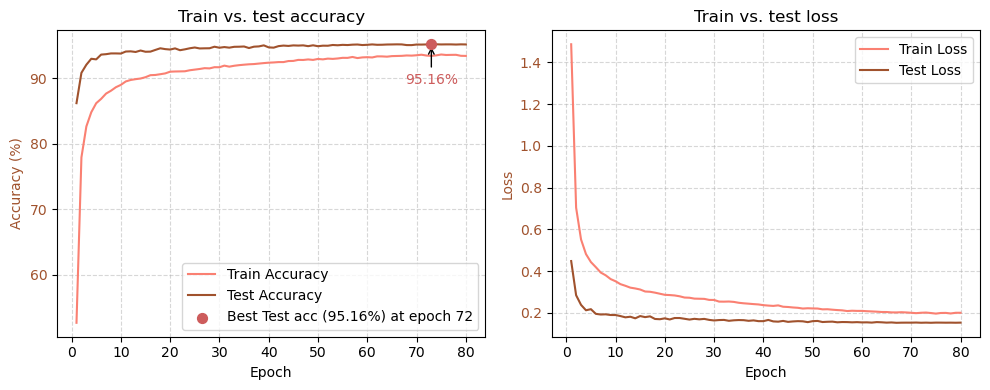

In [15]:
plot_stats(
    train_accuracies, 
    test_accuracies, 
    train_losses, 
    test_losses
)

### **Save results in file...**

In [13]:
results = "CNN_results.txt"
with open(results, "w") as f: 
    f.write("Epoch, Train loss, Train acc, Test loss, Test acc\n")
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, "
            f"{test_losses[i]:.4f}, "
            f"{test_accuracies[i]:.2f}%\n")
        
    f.write("\n===== Final Metrics =====\n")
    f.write(f"Final Train Loss: {final_train_loss:.4f}\n")
    f.write(f"Final Train Accuracy: {final_train_acc:.2f}%\n")
    f.write(f"Final Test Loss: {final_test_loss:.4f}\n")
    f.write(f"Final Test Accuracy: {final_test_acc:.2f}%\n")